Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
beginning....
...training accuracy 0.112
prob 0.100000, test accuracy 0.2002
...training accuracy 0.627
prob 0.250000, test accuracy 0.6712
...training accuracy 0.794
prob 0.300000, test accuracy 0.7662
...training accuracy 0.889
prob 0.500000, test accuracy 0.8617
...training accuracy 0.94
prob 0.700000, test accuracy 0.8934
...training accuracy 0.992
prob 0.750000, test accuracy 0.8968
...training accuracy 0.998
prob 0.800000, test accuracy 0.8973
...training accuracy 1
prob 1.000000, test accuracy 0.8813
Done!
[0.112, 0.62699997, 0.79400003, 0.889, 0.94, 0.99199998, 0.99800003, 1.0]
[0.20020001, 0.67119998, 0.76620001, 0.8617, 0.89340001, 0.89679998, 0.8973, 0.88129997]


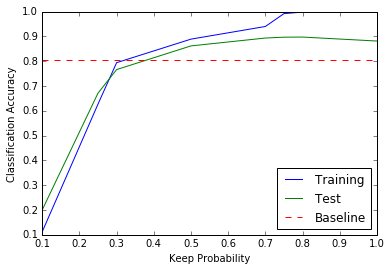

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.examples.tutorials.mnist import input_data

#
# ==================================================================
#

def weight_variable(shape):
    initial = tf.truncated_normal( shape, stddev=0.1 )
    return tf.Variable( initial )

def bias_variable(shape):
    initial = tf.constant( 0.1, shape=shape )
    return tf.Variable(initial)

#
# ==================================================================
#


learning_rate = 0.001

# Place holders
y_ = tf.placeholder( tf.float32, shape=[None, 10], name="y_" )
x = tf.placeholder( tf.float32, [None, 784], name="x" )
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
scale_val = tf.placeholder(tf.float32) 
s = False

# Defining computation graph for training
def trainWithDropConnection(X, scale):
    W1 = weight_variable([784, 500])
    b1 = bias_variable([500])
    
    # Weight Adding dropin
    u1 = tf.to_float(tf.less(tf.random_uniform(tf.shape(W1), minval=0, maxval=1), keep_prob))
    # Dropping in
    W1 *= u1
    
    if scale:
        W1 = tf.mul(W1, scale_val)
    # Bias Adding dropin
    #v1 = tf.to_float(tf.less(tf.random_normal(tf.shape(b1)), keep_prob))
    # Dropping in
    #b1 *= v1
    
    
    h1 = tf.nn.relu(tf.matmul( X, W1 ) + b1)
    
    W2 = weight_variable([500, 500])
    b2 = bias_variable([500])
    
    # Weight Adding dropin
    u2 = tf.to_float(tf.less(tf.random_uniform(tf.shape(W2), minval=0, maxval=1), keep_prob))
    # Dropping in
    W2 *= u2
    
    if scale:
        W2 = tf.mul(W2, scale_val)
        
    # Bias Adding dropin
    #v2 = tf.to_float(tf.less(tf.random_normal(tf.shape(b2)), keep_prob))
    # Dropping in
    #b2 *= v2
    
    
    h2 = tf.nn.relu(tf.matmul( h1, W2 ) + b2)


    W3 = weight_variable([500, 1000])
    b3 = bias_variable([1000])
    
    # Weight Adding dropin
    u3 = tf.to_float(tf.less(tf.random_uniform(tf.shape(W3), minval=0, maxval=1), keep_prob))
    # Dropping in
    W3 *= u3
    
    if scale:
        W3 = tf.mul(W3, scale_val)
    
    # Bias Adding dropin
    #v3 = tf.to_float(tf.less(tf.random_normal(tf.shape(b3)), keep_prob))
    # Dropping in
    #b3 *= v3
    
    h3 = tf.nn.relu(tf.matmul( h2, W3 ) + b3)

    out = h3
    return out


# Construct Training Model
out = trainWithDropConnection(x, s)
W4 = weight_variable([1000, 10])
b4 = bias_variable([10])
y_hat = tf.nn.softmax(tf.matmul(out, W4) + b4)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_hat), reduction_indices=[1]))
xent_summary = tf.scalar_summary( 'xent', cross_entropy )

correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_summary = tf.scalar_summary( 'accuracy', accuracy )

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

#
# ==================================================================
#

sess = tf.Session()
sess.run( tf.initialize_all_variables() )

#
# ==================================================================
#

# NOTE: we're using a single, fixed batch of the first 1000 images
mnist = input_data.read_data_sets( "MNIST_data/", one_hot=True )

images = mnist.train.images[ 0:1000, : ]
labels = mnist.train.labels[ 0:1000, : ]

keep_probs = [ 0.1, 0.25, 0.3, 0.5, 0.7, 0.75, 0.8, 1.0 ]
#keep_probs = [ 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.80, 0.85, 0.9, 0.95, 1.0 ]
trainingAcc = []
testAcc = []

print "beginning...."
for k_prob in keep_probs:
    sess.run( tf.initialize_all_variables() )
    s = False
    for i in range( 1500 ): 
        _, acc = sess.run( [ train_step, accuracy ], feed_dict={ x: images, y_: labels, keep_prob: k_prob, scale_val: 1} )
        
    print( "...training accuracy %g" % acc )
    trainingAcc.append(acc)
    s = True
    final_acc = sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1, scale_val: k_prob} )
    print( "prob %f, test accuracy %g" % (k_prob, final_acc) )
    testAcc.append(final_acc) 
    
print ("Done!")
print trainingAcc
print testAcc

baseline = 0.8068
plt.plot(keep_probs, trainingAcc, color="blue")
plt.plot(keep_probs, testAcc, color="green")
plt.axhline(baseline, color='r', linestyle='--')

plt.legend(['Training', 'Test', 'Baseline'], loc='lower right')
plt.xlabel("Keep Probability")
plt.ylabel("Classification Accuracy")
plt.show()

